# Smooooooothing

There are many ways to skin the cat, and there are even more options to use smoothing for ODE filtering.
Here is how.


In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from odefilter import ivpsolve, recipes

config.update("jax_enable_x64", True)
backend.select("jax")

In [10]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra(time_span=(0.0, 10.0))


@jax.jit
def vf(*ys, t, p):
    return f(*ys, *p)


num_derivatives = 2

## Terminal-value simulation

If you are interested in the terminal value of the ODE solution, you can use filters and smoothers interchangeably.
But be aware that a smoother computes more intermediate values than a filter, so filters are more efficient.

In [11]:
ek0, info_op = recipes.dynamic_isotropic_ekf0(num_derivatives=num_derivatives)
ek0sol = ivpsolve.simulate_terminal_values(
    vf,
    initial_values=(u0,),
    t0=t0,
    t1=t1,
    solver=ek0,
    info_op=info_op,
    parameters=f_args,
)
print(ek0sol.t, ek0sol.u)

10.0 [11.8195604   2.61399531]


## Traditional simulation

If you are used to calling traditional solve() methods, use one of the conventional smoothers (i.e. not the fixed-point smoothers).

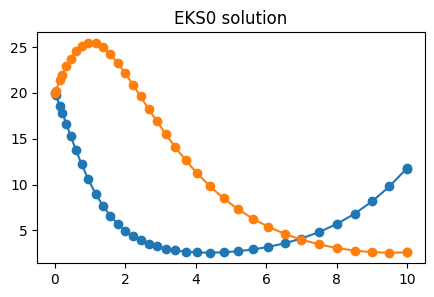

In [12]:
ek0, info_op = recipes.dynamic_isotropic_eks0(num_derivatives=num_derivatives)
ek0sol = ivpsolve.solve(
    vf,
    initial_values=(u0,),
    t0=t0,
    t1=t1,
    solver=ek0,
    info_op=info_op,
    parameters=f_args,
)

plt.subplots(figsize=(5, 3))
plt.title("EKS0 solution")
plt.plot(ek0sol.t, ek0sol.u, "o-")
plt.show()

If you like, compute the solution on a dense grid after solving.

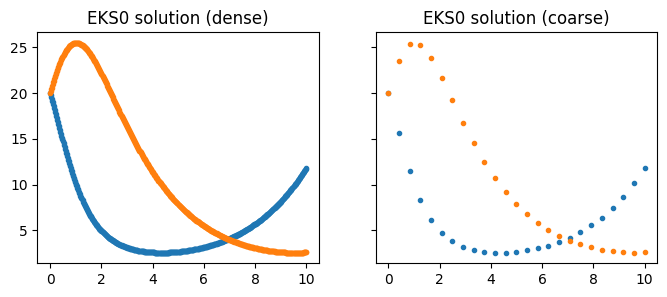

In [13]:
ts_dense = jnp.linspace(
    t0 + 1e-4, t1 - 1e-4, num=500, endpoint=True
)  # must be off-grid
dense = ek0.offgrid_marginals_searchsorted(ts=ts_dense, solution=ek0sol)

ts_coarse = jnp.linspace(
    t0 + 1e-4, t1 - 1e-4, num=25, endpoint=True
)  # must be off-grid
coarse = ek0.offgrid_marginals_searchsorted(ts=ts_coarse, solution=ek0sol)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 3))


ax1.set_title("EKS0 solution (dense)")
ax1.plot(dense.t, dense.u, ".")

ax2.set_title("EKS0 solution (coarse)")
ax2.plot(coarse.t, coarse.u, ".")
plt.show()

## Checkpoint simulation

If you know in advance that you like to have the solution at a pre-specified set of points only,
use the simulate_checkpoints function together with a fixed-point smoother.

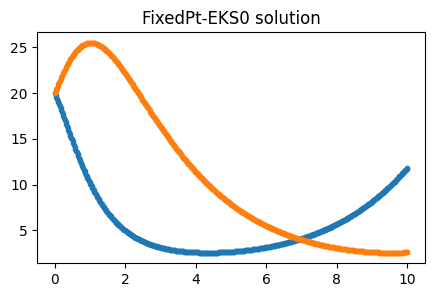

In [14]:
fixedpt_ek0, info_op = recipes.dynamic_isotropic_fixedpt_eks0(
    num_derivatives=num_derivatives
)
fixedptsol = ivpsolve.simulate_checkpoints(
    vf,
    initial_values=(u0,),
    ts=ts_dense,  # reuse from above
    solver=fixedpt_ek0,
    info_op=info_op,
    parameters=f_args,
)

plt.subplots(figsize=(5, 3))
plt.title("FixedPt-EKS0 solution")
plt.plot(fixedptsol.t, fixedptsol.u, ".-")
plt.show()